# A/B Инсайты: стратегия умных скидок


В данном проекте будем работать с сервисом по подписке. Это может быть что угодно, например, платформа для онлайн-игр или стриминговый сервис. Ключевой задачей для нас является удержание клиентов, для чего нам необходимо найти способы мотивировать их на продолжение использования сервиса. Появилась идея стимулирования пользователей путём предложения небольшой скидки, составляющей $1\%$ , на следующий период подписки.

Для проверки эффективности такого предложения проведем A/B тестирование - мы разделим наших пользователей на две группы: одной предоставем скидку, а другой нет.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sts
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [ ]:
df1 = pd.read_csv('subscribers_1.csv', sep=',')
print(df1.shape)
df1

(25935, 10)


,user_id,service_id,product_name,product_duration,rn,sale_date,last_duration_days,new_duration_days,is_same,group
0,47233,929,subscription,1_month,1,2018-12-21,30.0,30,1,0
1,50195,929,subscription,1_month,1,2019-03-17,30.0,30,1,1
2,62594,929,subscription,1_month,1,2019-02-08,30.0,30,1,0
3,68918,929,subscription,1_month,2,2019-03-19,30.0,30,1,1
4,91900,929,subscription,3_month,1,2018-10-29,30.0,90,0,0
...,...,...,...,...,...,...,...,...,...,...
25930,12885753927,929,subscription,1_month,1,2019-03-14,30.0,30,1,0
25931,12885754861,929,subscription,1_month,1,2019-03-21,30.0,30,1,1
25932,12885758998,929,subscription,1_month,1,2019-03-24,30.0,30,1,0
25933,12885759604,929,subscription,1_month,1,2019-03-24,30.0,30,1,1


* `rn` - порядковый номер покупки подписки за период.  
* `last_duration_days` - длительность предыдущей подписки.
* `new_duration_days` - длительность текущей подписки.
* `is_same` - менялась ли длительность подписки.
* `group` - группа теста, в которую попал пользователь. 1 - тест, 0 - контроль.

#**АБ-тест**

Посчитаем результаты АБ-теста. Найдем разницу между старой и новой длительностями подписки. Построим для этой разницы гистограмму.

KstestResult(statistic=0.5183388545444649, pvalue=0.0, statistic_location=0.0, statistic_sign=1)


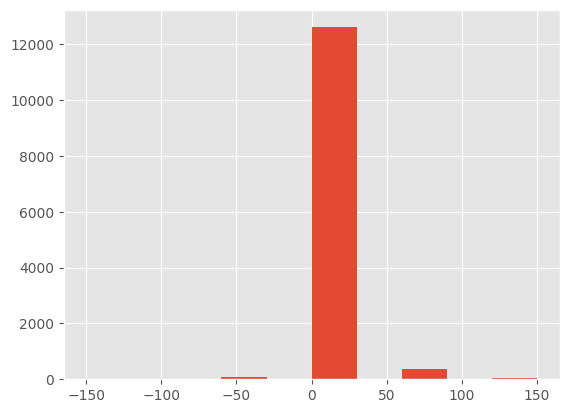

In [ ]:
df1['diff'] = df1.new_duration_days - df1.last_duration_days
df = df1[df1['group'] == 1]
df0 = df1[df1['group'] == 0]

plt.hist(df['diff'], bins = 10)

print(sts.kstest(df['diff'], 'norm', args=(df['diff'].mean(), df['diff'].std(ddof=1))))


По результатам теста Колмогорова-Смирнова, который дал p-значение равное 0.0, распределение значительно отклоняется от нормального.

На основе этого подумаем, какими тестами сможем пользоваться.

1. Использваоние **теста Уэлча** может быть не целесообразным, так как он используется для сравнения средних двух групп, когда предполагается нормальность распределений и не предполагается равенство дисперсий. А у нас распределение значительно отличается от нормальгого.

2. Использование **ЦПТ** так же может дать некорректные результаты, так как распределение сильно отличается от нормального с высокой куртозой.

Необходимо воспользоваться непараметричнескими тестами! Например, тестом **Манна-Утни**.



In [ ]:
from scipy.stats import mannwhitneyu

u_statistic, p_value = mannwhitneyu(df['diff'], df0['diff'], alternative='two-sided')

print(f'U-Statistic: {u_statistic}')
print(f'P-Value: {p_value}')





U-Statistic: 83911446.0
P-Value: 0.46758711046825796


In [ ]:
from statsmodels.stats.weightstats import ttest_ind

z_obs, pvalue, df_n = ttest_ind(df0['diff'], df['diff'], value=0, alternative='two-sided')

print(f'Z_obs: {z_obs}')
print(f'P-Value: {pvalue}')

Z_obs: 0.7478357337395307
P-Value: 0.4545660265872755


Заметим, что оба теста дают высокий pvalue, что означает, что статистически значимых различий в распределениях между контрольной и тестовой группами не наблюдается. Следовательно, можно сделать вывод, что дабавление скидки не оказало значительного влияния.

# **ААБ-тест**

Представим, что мы продвинутые АБ-тестеры и решили провести ААБ тест (2 контрольные группы и одну тестовую)

In [ ]:
df2 = pd.read_csv('subscribers_2.csv', sep=',')
print(df2.shape)
df2.head( )

(25935, 10)


,user_id,service_id,product_name,product_duration,rn,sale_date,last_duration_days,new_duration_days,is_same,new_group
0,47233,929,subscription,1_month,1,2018-12-21,30.0,30,1,0
1,50195,929,subscription,1_month,1,2019-03-17,30.0,30,1,2
2,62594,929,subscription,1_month,1,2019-02-08,30.0,30,1,0
3,68918,929,subscription,1_month,2,2019-03-19,30.0,30,1,2
4,91900,929,subscription,3_month,1,2018-10-29,30.0,90,0,0


* `new_group` - группа теста, в которую попал пользователь. $2$ - тест, $0,1$ - контроль.

Проверим гипотезу о том, что в каждой из контрольных групп среднее совпадает с тестовой на уровне значимости $1\%$. Сделаем корректировку методом Холма для контроля над ложноположительными результатами при множественных сравнениях

In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests

df2['diff'] = df2.new_duration_days - df2.last_duration_days
df0 = df2[df2['new_group'] == 0]
df1 = df2[df2['new_group'] == 1]
df22 = df2[df2['new_group'] == 2]

pval_1 = ttest_ind(df0['diff'], df22['diff'], value=0, alternative='two-sided')[1]
pval_2 = ttest_ind(df1['diff'], df22['diff'], value=0, alternative='two-sided')[1]

p_values = [pval_1, pval_2]

rejected, p_corrected, _, _ = multipletests(p_values,
                                            alpha = 0.01, method = 'holm')
hyp_cnt = sum(rejected)
pval_1 , pval_2, hyp_cnt, p_corrected

result_text = (
    f"Результаты t-тестов и коррекции множественных сравнений методом Холма:\n"
    f"P-значение теста между группами 0 и 2 (Pval 1): {pval_1:.4f}\n"
    f"P-значение теста между группами 1 и 2 (Pval 2): {pval_2:.4f}\n"
    f"Исправленные P-значения после коррекции Холма: {p_corrected}\n"
)

print(result_text)

Результаты t-тестов и коррекции множественных сравнений методом Холма:
P-значение теста между группами 0 и 2 (Pval 1): 0.4472
P-значение теста между группами 1 и 2 (Pval 2): 0.3323
Исправленные P-значения после коррекции Холма: [0.66455158 0.66455158]



**Вывод:** получили p-значения выше порога значимости 0.01,что указывает на отсутствие статистически значимых различий. После коррекции Холма p-значения даже увеличились, подтверждая предыдущий вывод. Следовательно, ни одна гипотеза не отвергается, что говорит о том, что наблюдаемые различия между группами, вероятно, не являются статистически значимыми.
